# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [45]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTForImageClassification

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [46]:
# random seed
SEED = 1 
NUM_CLASS = 10

BATCH_SIZE = 128
NUM_EPOCHS = 15
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 0.01
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [48]:
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [49]:
# 这个网络承载能力不太行，只能达到40%左右的准确率，故而换成了下面的网络（请见下一个代码块）
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = ConvNet()
model.to(device)

In [56]:
class AlexNetStyleNet(nn.Module):
    def __init__(self):
        super(AlexNetStyleNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10) 
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
model = AlexNetStyleNet()
model.to(device)

In [68]:
from torchvision import models
model = models.resnet18(pretrained=True)
# Modify the last layer to fit the CIFAR-10 output size
model.fc = nn.Linear(512, 10)  # For ResNet-18
model = model.to(device)

c:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Optimizer

In [69]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [70]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()


In [71]:
def train_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    output = model(image)
    loss = criterion(output, target)
    return output, loss


### Model Training

In [72]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0102 Acc: 0.5408
Begin test......
Test Loss: 0.0076 Acc: 0.6649
Epoch: 2/30 Train Loss: 0.0070 Acc: 0.6876
Begin test......
Test Loss: 0.0062 Acc: 0.7265
Epoch: 3/30 Train Loss: 0.0060 Acc: 0.7317
Begin test......
Test Loss: 0.0056 Acc: 0.7512
Epoch: 4/30 Train Loss: 0.0054 Acc: 0.7563
Begin test......
Test Loss: 0.0052 Acc: 0.7730
Epoch: 5/30 Train Loss: 0.0050 Acc: 0.7744
Begin test......
Test Loss: 0.0051 Acc: 0.7775
Epoch: 6/30 Train Loss: 0.0046 Acc: 0.7954
Begin test......
Test Loss: 0.0047 Acc: 0.7945
Epoch: 7/30 Train Loss: 0.0044 Acc: 0.8024
Begin test......
Test Loss: 0.0047 Acc: 0.7962
Epoch: 8/30 Train Loss: 0.0043 Acc: 0.8077
Begin test......
Test Loss: 0.0046 Acc: 0.7983
Epoch: 9/30 Train Loss: 0.0041 Acc: 0.8148
Begin test......
Test Loss: 0.0046 Acc: 0.8013
Epoch: 10/30 Train Loss: 0.0040 Acc: 0.8200
Begin test......
Test Loss: 0.0045 Acc: 0.8074
Epoch: 11/30 Train Loss: 0.0038 Acc: 0.8265
Begin test......
Test Loss: 0.0044 Acc: 0.8082
Epoch: 1

KeyboardInterrupt: 

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [73]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [74]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
input = input.to(device)
output = model(input.unsqueeze(0))
probabilities = torch.softmax(output, dim=1)
predict_label = torch.argmax(probabilities)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


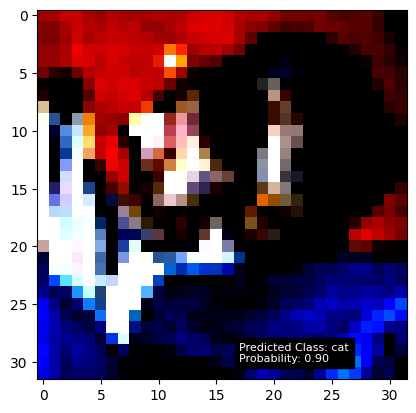

Print probabilities for each class:
airplane: 0.0021
automobile: 0.0049
bird: 0.0083
cat: 0.8974
deer: 0.0001
dog: 0.0842
frog: 0.0011
horse: 0.0003
ship: 0.0008
truck: 0.0007


[None, None, None, None, None, None, None, None, None, None]

In [75]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0, predict_label].item()

image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
[print(f'{class_names[i]}: {probabilities[0, i].item():.4f}') for i in range(len(class_names))]

# Test with ViT model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
import timm
import os
import numpy as np
import matplotlib.pyplot as plt

In [10]:
learning_rate = 1e-03
train_batch_size = 32
eval_batch_size = 32
seed = 42
gradient_accumulation_steps = 4
total_train_batch_size = 128
optimizer = 'Adam'
lr_scheduler_type = 'linear'
lr_scheduler_warmup_ratio = 0.1
num_epochs = 1

l1_weight = 0.01

In [3]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
resize_size = 224  

transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((resize_size, resize_size)),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_cifar10_train)
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_cifar10_test)
test_loader = DataLoader(test_set, batch_size=eval_batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [6]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=10)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/root/miniconda3/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [13]:
criterion = nn.CrossEntropyLoss().to(device)

if optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
else:
    raise ValueError("Optimizer not supported")

if lr_scheduler_type == 'linear':
    num_steps = len(train_loader) * num_epochs
    warmup_steps = int(num_steps * lr_scheduler_warmup_ratio)
    lr_scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: min((step + 1) / warmup_steps, 1.0),
    )
else:
    raise ValueError("Learning rate scheduler not supported")

In [8]:
import os
checkpoint_dir = "/root/autodl-tmp/STA303-Assignment01/ViT_checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)


save_checkpoint_interval = 1  
max_saved_checkpoints = 5  

saved_checkpoints = []

In [15]:
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            l1_regularization = 0.5 * l1_weight * sum(w.abs().sum() for w in model.parameters())
            loss1 = l1_regularization + loss

            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += targets.size(0)
            total_loss += loss1.item()
    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

def train(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for step, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            l1_regularization = 0.5 * l1_weight * sum(w.abs().sum() for w in model.parameters())
            loss1 = l1_regularization + loss

            loss1.backward()
            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
            if (step + 1) % 10 == 0:  # 每10个小批次打印一次
                print(f"Training Loss: {loss.item():.4f}\tEpoch: {epoch+1}\tStep: {step+1}")
                # 保存模型检查点
                if (step + 1) % save_checkpoint_interval == 0:
                    checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch{epoch+1}_step{step+1}.pt')
                    torch.save({
                        'epoch': epoch,
                        'step': step,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                    }, checkpoint_path)
                    print(f"Saved checkpoint at {checkpoint_path}")
                    
                    # 将检查点路径添加到列表中
                    saved_checkpoints.append(checkpoint_path)
                    
                    # 检查并删除旧的检查点
                    if len(saved_checkpoints) > max_saved_checkpoints:
                        old_checkpoint = saved_checkpoints.pop(0)
                        os.remove(old_checkpoint)
                        print(f"Removed old checkpoint: {old_checkpoint}")
                if (step + 1) % 100 == 0:  # 每100个小批次打印一次
                    validation_loss, accuracy = evaluate(model, test_loader)
                    print(f"Test Loss: {validation_loss:.4f}\tAccuracy: {100 * accuracy:.2f}%")


In [16]:
# Training
train(model, train_loader, optimizer, criterion, num_epochs)

Training Loss: 2.9320	Epoch: 1	Step: 10
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step10.pt
Training Loss: 3.4195	Epoch: 1	Step: 20
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step20.pt
Training Loss: 3.0313	Epoch: 1	Step: 30
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step30.pt
Training Loss: 2.4472	Epoch: 1	Step: 40
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step40.pt
Training Loss: 2.2982	Epoch: 1	Step: 50
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step50.pt
Training Loss: 2.2393	Epoch: 1	Step: 60
Saved checkpoint at /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step60.pt
Removed old checkpoint: /root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step10.pt
Training Loss:

In [19]:
checkpoint_path = '/root/autodl-tmp/STA303-Assignment01/ViT_checkpoint/model_checkpoint_epoch1_step1560.pt'
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
step = checkpoint['step']
loss = checkpoint['loss']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


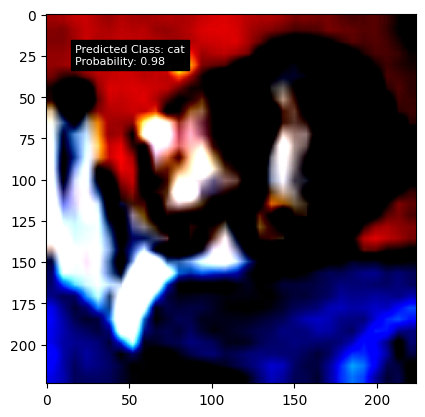

Print probabilities for each class:
airplane: 0.0014
automobile: 0.0058
bird: 0.0003
cat: 0.9809
deer: 0.0014
dog: 0.0035
frog: 0.0050
horse: 0.0004
ship: 0.0006
truck: 0.0006


[None, None, None, None, None, None, None, None, None, None]

In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

inputs, classes = next(iter(test_loader))
input = inputs[0]
input = input.to(device)
output = model(input.unsqueeze(0))
probabilities = torch.softmax(output, dim=1)
predict_label = torch.argmax(probabilities)
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0, predict_label].item()

image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
[print(f'{class_names[i]}: {probabilities[0, i].item():.4f}') for i in range(len(class_names))]